In [1]:
# Libraries import

import os, gc
import numpy as np
#import pickle
import joblib
import pandas as pd
import sys
import matplotlib.pyplot as plt

from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import SVC
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import confusion_matrix, auc, RocCurveDisplay

np.set_printoptions(suppress=True, precision = 3)

# Notes 

## Model architecture 
We train a random forest classifier, using a 5-fold cross-validation. The validation folds are designed using over-sampling so that in each fold, the validation set contains at least one tumor from each class, but possibly more so that each class has at least 15% of its data in validation. 

We select the most important features from the random forest model for experimental validation. We also use them to train a support vector classifier model, to boost the quality of the model. 

In [2]:
"""
DATA DESCRIPTION
Indicate the file names for the pre-processed data and for the tumor/non-tumor map. 
The pre-processed data is a list of dictionaries, one for each sample, each dictionary has the 2D x 1738 data
plus its methylation label, sample name, patient ID, , t-SNE and PCA decompositions (datastructure described below).
The tumor/non-tumor map is a list of numpy arrays, one for each sample, of the same 2D shape as the 
corresponding sample, coming in the same order as the samples in the pre-processed file. 
Each entry in the 2D array is 0/1, with 1 indicating that the corresponding spot in the pre-processed data 
was labeled as tumor. 
The map is to be used as filter: only those spot labeled as tumor are to be analysed further. 
We also use the map to extract the most discriminative features between tumor and non-tumor. 
"""

PREPROC_DATA_PATH = "../data/preprocessed.npy"
TUMOR_MAP_PATH = "../data/tumor_maps.npy"
BINARY_CLASSIFIER_PATH = "./BinaryMethylModels/" 

# Make the directory if it doesn't exist
if not os.path.exists(BINARY_CLASSIFIER_PATH[2:-1]):
    os.mkdir(BINARY_CLASSIFIER_PATH[2:-1])

SAMPLE_DICT_DATA_KEY = "data"
SAMPLE_DICT_NAME_KEY = "name"
SAMPLE_DICT_CLASS_ID_KEY = "class_id"
SAMPLE_DICT_PATIENT_ID_KEY = "patient_id"
SAMPLE_DICT_TSNE_KEY = "tsne"
SAMPLE_DICT_PCA_KEY = "pca"

# Define the samples to be excluded from the analysis (use their full name)
ignore = ["HF-1887_via-t_2_1.h5_3"]

In [3]:
"""
CROSS-VALIDATION DESIGN: 5-fold
All samples (except 1887) included. Assigned to the CV folds in order of their names, 
trying to have about the same amount of validation data in each fold.
Date: February 2023. 
"""

CV5folds=[ 
    [#Cv fold 1
        #LGm1 
        "HF-448_V5B_1.h5_3",
        #LGm2
        "HF-305_v4b_1_1.h5_6", "HF-615_V5BB_1.h5_9",  
        #LGm3
        "HF-2104_#5_1.h5_0", "HF-2104_#9_1.h5_1", "HF-2104_V1T_1.h5_2",
        #LGm4
        "HF-442_V4BB_1.h5_12", "HF-1002_V1AT_1.h5_0", "HF-1002_V2AT_1.h5_1", 
        #LGm5
        "HF-682_V3AT_1.h5_9", "HF-682_V3BB_1.h5_10", "HF-894_9_1.h5_11", "HF-894_V1BB_1.h5_12", 
        #LGm6
        "HF-592_V3T_1.h5_4", 
    ],
    [#Cv fold 2
        #LGm1 
        "HF-868_1_2.h5_4",
        #LGm2
        "HF-901_V2T_2.h5_10", "HF-960_VIAT_2.h5_11", 
        #LGm3
        "HF-2614_V1B_1.h5_3", 
        #LGm4
        "HF-1825_V2B_1.h5_2", "HF-2102_V2BB_1.h5_3", "HF-2102_V3AM_1.h5_4", "HF-2102_V3AM_2.h5_5", 
        #LGm5
        "HF-988_V1-T_1.h5_13", "HF-988_V1B_1.h5_14", "HF-1043_V1AM_1.h5_0", 
        #LGm6
        "HF-2106_V3AM_1.h5_0", 
    ], 
    [#Cv fold 3
        #LGm1 
        "HF-1293_13_1.h5_0",
        #LGm2
        "HF-1010_V1T_1.h5_0", "HF-1016_IAT_2.h5_1", "HF-1334_V58-B_2_1.h5_2", 
        #LGm3
        "HF-2849_VIT2_1.h5_4", "HF-2849_VIT2_1.h5_5", "HF-2849_VIT2_2.h5_6", "HF-2849_VIT_2_new2021.h5_7",
        #LGm4
        "HF-2454_V1AT_1.h5_6", "HF-2548_V1T_1.h5_7", 
        #LGm5
        "HF-1086_#1_1.h5_1", "HF-2355_V2AM_1.h5_2", 
        #LGm6
        "HF-2493_V1T_1.h5_1", "HF-2493_V1T_2.h5_2", 
    ], 
    [#Cv fold 4
        #LGm1 
        "HF-1295_V3AM_2.h5_1",
        #LGm2
        "HF-2070_V1T_1.h5_4", "HF-2776_V2B_2.h5_5",        
        #LGm3 
        "HF-2852_VIT_2_2.h5_8", 
        #LGm4
        "HF-2715_VIL_1.h5_8", "HF-2802_V3T_1.h5_9", 
        #LGm5
        "HF-2485_V1B_1.h5_3", "HF-2600_V1B_1.h5_4", "HF-2608_V1T_1.h5_5", 
        #LGm6
        "HF-2544_V1B_1.h5_3", 
    ],
    [#Cv fold 5
        #LGm1 
        "HF-2534_V2B_1.h5_2",
        #LGm2
        "HF-3271_VIB_2.h5_7", "HF-3337_V3T_1.h5_8", 
        #LGm3 same as fold 1
        "HF-2104_#5_1.h5_0", "HF-2104_#9_1.h5_1", "HF-2104_V1T_1.h5_2",
        #LGm4
        "HF-2876_V1T_1.h5_10", "HF-2898_V1T_1.h5_11",
        #LGm5
        "HF-2619_V1T_1.h5_6", "HF-2619_V4T_1.h5_7", "HF-2666_V2B_1.h5_8",
        #LGm6 same as fold 1
        "HF-592_V3T_1.h5_4", 
    ],
]

In [4]:
def reset_seed(SEED = 0):
    os.environ['PYTHONHASHSEED']=str(SEED)
    np.random.seed(SEED)
    
reset_seed(2022)

In [5]:
def CrossValidation(data, labels, CV_folds=CV5folds, verbose=False):
    """ 
    This is the cross-validation training. 
    In each CV fold, the model is first trained, then the data reduced to its top 20 features
    and the model is re-trained with an SVC. 
    This is in the hope of reducing the noise and getting a better fit.
    We save all RF and SVC models, as well as their metrics. 
    """
    
    results = []  
    RFmetrics=[]
    SVCmetrics=[]
    index = 0
    
    # Initialize the ROC curve plotting data
    RFtprs = []
    RFaucs = []
    SVCtprs = []
    SVCaucs = []
    mean_fpr = np.linspace(0, 1, 100)
    RFfig, RFax = plt.subplots(figsize=(6, 6))
    SVCfig, SVCax = plt.subplots(figsize=(6, 6))

    # Loop through the CV folds
    for valid_fold in CV_folds:
        
        index = index+1
        if verbose: 
            print("Validation fold", index)
        CV_fold_name=str(index)

        # Get the train/validation data for this CV fold
        train_X=np.empty( (0,data[0][SAMPLE_DICT_DATA_KEY].shape[1]) )
        train_y=np.empty( 0 )
        valid_names=[]
        valid_X=np.empty( (0,data[0][SAMPLE_DICT_DATA_KEY].shape[1]) )
        valid_y=np.empty( 0 )
        for (sample,label) in zip(data,labels): 
            if sample[SAMPLE_DICT_NAME_KEY] in valid_fold:
                valid_names.append(sample[SAMPLE_DICT_NAME_KEY])
                valid_X = np.append(valid_X, sample[SAMPLE_DICT_DATA_KEY], axis=0)
                valid_y = np.append(valid_y, label, axis=0)
            else: 
                train_X = np.append(train_X, sample[SAMPLE_DICT_DATA_KEY], axis=0)
                train_y = np.append(train_y, label, axis=0)
        if len(valid_names) != len(valid_fold):
            print("Error in the design of CV fold (data not found):", valid_fold)
            sys.exit(-1)    
            
        # Create list of indices
        shuffle = np.arange(len(train_X))
        
        # Numpy shuffle method performs shuffle in place
        np.random.shuffle(shuffle)
        
        # Shuffle the training data
        train_X = np.squeeze(train_X[shuffle])
        train_y = np.squeeze(train_y[shuffle])
    
        # Create RF model and train to extract features
        RFclf = RandomForestClassifier(n_estimators = 300,
                            bootstrap = True,
                            max_depth = 10,
                            random_state=0,
                            criterion = "entropy",
                            class_weight = "balanced_subsample",
                            warm_start = False,
                            n_jobs = -1,
                            min_samples_leaf = 50,
                            min_samples_split = 50,
                            max_features = "sqrt"
                            )

        RFclf.fit(train_X, train_y)
        
        # Get accuracy on training and validation data
        acc_train = RFclf.score(train_X, train_y)
        acc_val = RFclf.score(valid_X, valid_y)
        if verbose: 
            print("\t RF model. Accuracy on train and valid: ", acc_train, acc_val)
        
        # Get prediction on the validation data
        pred = RFclf.predict(valid_X)
        
        # Gather RF metrics
        RFacc = balanced_accuracy_score(valid_y, pred)
        RFroc_auc = roc_auc_score(valid_y, pred, average = None)
        RFprec = precision_score(valid_y, pred, average = None)
        RFrec = recall_score(valid_y, pred, average = None)
        RFf1 = f1_score(valid_y, pred, average = None)
        RFconf = confusion_matrix(valid_y, pred, normalize='true')
        RFmetrics.append([RFacc, RFroc_auc, RFprec, RFrec, RFf1, RFconf])
        
        if verbose: 
            print("\t RF accuracy: ", RFacc)
            print("\t RF AUROC:    ", RFroc_auc)
            print("\t RF precision:", RFprec)
            print("\t RF recall:   ", RFrec)
            print("\t RF F1:       ", RFf1)
            print("\t RF confusion matrix:\n", RFconf)
                   
        # Collect and plot the ROC curve
        RFviz = RocCurveDisplay.from_estimator(
            RFclf,
            valid_X,
            valid_y,
            name=f"RF ROC cv fold {index}",
            alpha=0.3,      # used for setting the transparency/opacity level
            linewidth=1,
            ax=RFax,
        )
        
        # Collect the true positive vs. false positive rates and interpolation 
        RFinterp_tpr = np.interp(mean_fpr, RFviz.fpr, RFviz.tpr)
        RFinterp_tpr[0] = 0.0
        RFtprs.append(RFinterp_tpr)
        RFaucs.append(RFviz.roc_auc)                    
                        
        # Save the model
        joblib.dump(RFclf, BINARY_CLASSIFIER_PATH+"RF_" + CV_fold_name + ".RFmod")
        
        # Save the feature importance vector
         
        # get a selector on the top 20 features
        selector = SelectFromModel(RFclf, prefit=True, threshold=-np.inf, max_features=20)
        del RFclf
        
        # project the training and the validation data
        sel_train_X=selector.transform(train_X)
        sel_valid_X=selector.transform(valid_X)
        
        # Create a classifier: a support vector RBF classifier on the reduced features

        SVCclf = SVC(C=1.0, kernel='rbf', gamma='scale',
                  probability=False, 
                  class_weight='balanced', 
                  decision_function_shape='ovo',
                  random_state = 0)

        SVCclf.fit(sel_train_X, train_y)
        
        # Get accuracy on training and validation data
        acc_sel_train = SVCclf.score(sel_train_X, train_y)
        acc_sel_val = SVCclf.score(sel_valid_X, valid_y)
        if verbose: 
            print("\t Reduced SVC model. Accuracy on train and valid: ", acc_sel_train, acc_sel_val)
        
        # Collect and plot the ROC curve
        SVCviz = RocCurveDisplay.from_estimator(
            SVCclf,
            sel_valid_X,
            valid_y,
            name=f"SVC ROC cv fold {index}",
            alpha=0.3,      # used for setting the transparency/opacity level
            linewidth=1,
            ax=SVCax,
        )
        
        # Collect the true positive vs. false positive rates and interpolation 
        SVCinterp_tpr = np.interp(mean_fpr, SVCviz.fpr, SVCviz.tpr)
        SVCinterp_tpr[0] = 0.0
        SVCtprs.append(SVCinterp_tpr)
        SVCaucs.append(SVCviz.roc_auc)        

        # save the model to disk
        joblib.dump(SVCclf, BINARY_CLASSIFIER_PATH+"SVC_" + CV_fold_name + ".SVCmod")
        
        # Get prediction on all spectra
        pred = SVCclf.predict(sel_valid_X)
        
        # Gather SVC metrics
        SVCacc = balanced_accuracy_score(valid_y, pred)
        SVCroc_auc = roc_auc_score(valid_y, pred, average = None)
        SVCprec = precision_score(valid_y, pred, average = None)
        SVCrec = recall_score(valid_y, pred, average = None)
        SVCf1 = f1_score(valid_y, pred, average = None)
        SVCconf = confusion_matrix(valid_y, pred, normalize='true')
        SVCmetrics.append([SVCacc, SVCroc_auc, SVCprec, SVCrec, SVCf1, SVCconf])
        
        if verbose: 
            print("\t SVC accuracy: ", SVCacc)
            print("\t SVC AUROC:    ", SVCroc_auc)
            print("\t SVC precision:", SVCprec)
            print("\t SVC recall:   ", SVCrec)
            print("\t SVC F1:       ", SVCf1)
            print("\t SVC confusion matrix:\n", SVCconf)
            
        # Clear memory
        del SVCclf
        del train_X
        del train_y
        del valid_X
        del valid_y
        del sel_train_X
        del sel_valid_X
        gc.collect()
        
    # Plot the ROC curves for each of the folds, as well as the mean curve and SD
    RFax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    SVCax.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")

    RFmean_tpr = np.mean(RFtprs, axis=0)
    RFmean_tpr[-1] = 1.0
    RFmean_auc = auc(mean_fpr, RFmean_tpr)
    RFstd_auc = np.std(RFaucs)

    SVCmean_tpr = np.mean(SVCtprs, axis=0)
    SVCmean_tpr[-1] = 1.0
    SVCmean_auc = auc(mean_fpr, SVCmean_tpr)
    SVCstd_auc = np.std(SVCaucs)

    RFax.plot(
        mean_fpr,
        RFmean_tpr,
        color="b",
        label=r"RF mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (RFmean_auc, RFstd_auc),
        linewidth=2,
        alpha=0.8,      # used for setting the transparency/opacity level
    )

    SVCax.plot(
        mean_fpr,
        SVCmean_tpr,
        color="b",
        label=r"SVC mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (SVCmean_auc, SVCstd_auc),
        linewidth=2,
        alpha=0.8,      # used for setting the transparency/opacity level
    )

    # Calculate and plot the standard deviation around the mean ROC curve of the CV folds
    RFstd_tpr = np.std(RFtprs, axis=0)
    RFtprs_upper = np.minimum(RFmean_tpr + RFstd_tpr, 1)
    RFtprs_lower = np.maximum(RFmean_tpr - RFstd_tpr, 0)

    SVCstd_tpr = np.std(SVCtprs, axis=0)
    SVCtprs_upper = np.minimum(SVCmean_tpr + SVCstd_tpr, 1)
    SVCtprs_lower = np.maximum(SVCmean_tpr - SVCstd_tpr, 0)
    
    RFax.fill_between(
        mean_fpr,
        RFtprs_lower,
        RFtprs_upper,
        color="grey",
        alpha=0.2,      # used for setting the transparency/opacity level
        label=r"$\pm$ 1 std. dev.",
    )

    SVCax.fill_between(
        mean_fpr,
        SVCtprs_lower,
        SVCtprs_upper,
        color="grey",
        alpha=0.2,      # used for setting the transparency/opacity level
        label=r"$\pm$ 1 std. dev.",
    )

    RFax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"A. Mean ROC curve of the RF model with variability",
    )
    RFax.axis("square")
    RFax.legend(loc="lower right")
    
    SVCax.set(
        xlim=[-0.05, 1.05],
        ylim=[-0.05, 1.05],
        xlabel="False Positive Rate",
        ylabel="True Positive Rate",
        title=f"B. Mean ROC curve of the SVC model with variability",
    )
    SVCax.axis("square")
    SVCax.legend(loc="lower right")
    
    plt.show()

    return RFmetrics, SVCmetrics

In [6]:
# Read the pre-processed data and the tumor map of each sample
samples_0 = np.load(PREPROC_DATA_PATH, allow_pickle=True)
tumor_map_0 = np.load(TUMOR_MAP_PATH, allow_pickle=True)

samples = []
labels=[]

# Filter the data: retain only the tumor spots, based on the tumor map  
# Flatten the data (no spatial info needed here) 
# Skip the samples on the "ignore" list

for (sample, tumor) in zip(samples_0, tumor_map_0):    
    if sample[SAMPLE_DICT_NAME_KEY] in ignore:
        print("Sample ignored:", sample[SAMPLE_DICT_NAME_KEY])
        continue
    
    sample[SAMPLE_DICT_DATA_KEY] = sample[SAMPLE_DICT_DATA_KEY].reshape(-1, sample[SAMPLE_DICT_DATA_KEY].shape[2])
    tumor.resize(np.product(tumor.shape))
    sample[SAMPLE_DICT_DATA_KEY] = sample[SAMPLE_DICT_DATA_KEY][tumor == 1]
    samples.append(sample)
    
    # Switch to binary methylation labels: mutant/0 (LGm1-3) and wild-type/1 (LGm4-6)
    label = np.where(sample[SAMPLE_DICT_CLASS_ID_KEY]<4, 0, 1)
    
    # All spots get as label the methylation label of the entire sample
    labels.append(label*np.ones(sample[SAMPLE_DICT_DATA_KEY].shape[0]))
    
del samples_0
del tumor_map_0
gc.collect()

Sample ignored: HF-1887_via-t_2_1.h5_3


11

Validation fold 1
	 RF model. Accuracy on train and valid:  0.936356447120887 0.6022270646328542
	 RF accuracy:  0.5862619217748686
	 RF AUROC:     0.5862619217748686
	 RF precision: [0.666 0.584]
	 RF recall:    [0.311 0.861]
	 RF F1:        [0.424 0.696]
	 RF confusion matrix:
 [[0.311 0.689]
 [0.139 0.861]]
	 Reduced SVC model. Accuracy on train and valid:  0.896167240540899 0.6313548309709922
	 SVC accuracy:  0.6138188834213409
	 SVC AUROC:     0.6138188834213409
	 SVC precision: [0.767 0.599]
	 SVC recall:    [0.312 0.916]
	 SVC F1:        [0.443 0.724]
	 SVC confusion matrix:
 [[0.312 0.688]
 [0.084 0.916]]
Validation fold 2
	 RF model. Accuracy on train and valid:  0.8839670160045495 0.7635888747705775
	 RF accuracy:  0.7547694515526031
	 RF AUROC:     0.7547694515526031
	 RF precision: [0.727 0.789]
	 RF recall:    [0.7  0.81]
	 RF F1:        [0.713 0.799]
	 RF confusion matrix:
 [[0.7  0.3 ]
 [0.19 0.81]]
	 Reduced SVC model. Accuracy on train and valid:  0.819375050775855 0.8

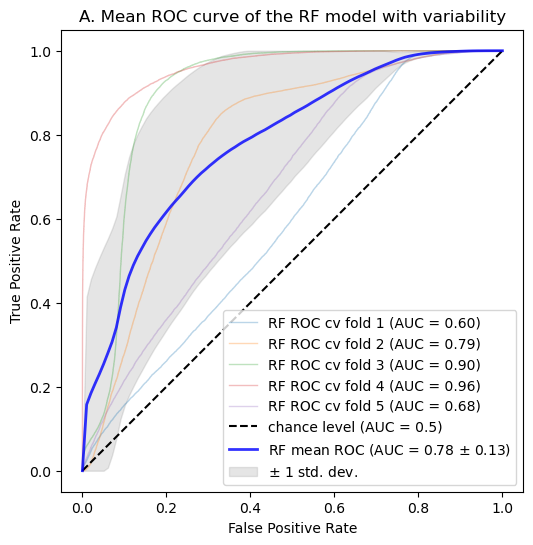

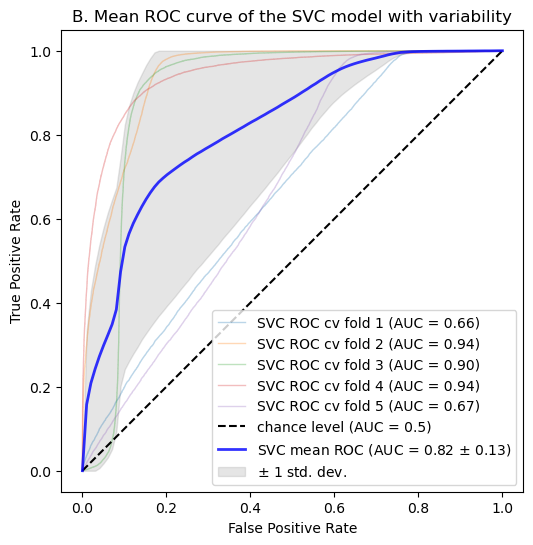

In [7]:
reset_seed(2022)
RFmetrics, SVCmetrics = CrossValidation(data=samples, labels=labels, CV_folds=CV5folds, verbose=True)

In [8]:
del samples
del labels
gc.collect()

11223

In [9]:
results = np.mean(np.asanyarray(RFmetrics, dtype=object), axis=0)
print("\t Mean RF accuracy: ", results[0])
print("\t Mean RF AUROC: ", results[1])
print("\t Mean RF precision:", results[2])
print("\t Mean RF recall:   ", results[3])
print("\t Mean RF F1:       ", results[4])
print("\t Mean RF confusion matrix:\n", results[5])

	 Mean RF accuracy:  0.7453206085926032
	 Mean RF AUROC:  0.7453206085926032
	 Mean RF precision: [0.806 0.702]
	 Mean RF recall:    [0.636 0.855]
	 Mean RF F1:        [0.693 0.762]
	 Mean RF confusion matrix:
 [[0.636 0.364]
 [0.145 0.855]]


In [10]:
results = np.mean(np.asanyarray(SVCmetrics, dtype=object), axis=0)
print("\t Mean SVC accuracy: ", results[0])
print("\t Mean SVC AUROC: ", results[1])
print("\t Mean SVC precision:", results[2])
print("\t Mean SVC recall:   ", results[3])
print("\t Mean SVC F1:       ", results[4])
print("\t Mean SVC confusion matrix:\n", results[5])

	 Mean SVC accuracy:  0.780960359958126
	 Mean SVC AUROC:  0.780960359958126
	 Mean SVC precision: [0.865 0.734]
	 Mean SVC recall:    [0.671 0.891]
	 Mean SVC F1:        [0.731 0.794]
	 Mean SVC confusion matrix:
 [[0.671 0.329]
 [0.109 0.891]]
